In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve, minimize, basinhopping

In [3]:
# Load spectrum data:
df = pd.read_excel('espectro.xlsx')
lambdas = df['Lambda (nm)'].values
film = df['Película'].values
glass = df['Vidrio'].values
cut = np.where(lambdas > 530)
lambdas = lambdas[cut]
film = film[cut]
glass = glass[cut]

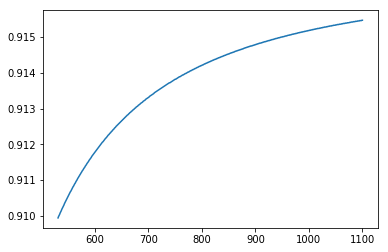

In [4]:
# Value of glass transmision is almost constant, which indicates that the index of refraction is almost constant as well.
plt.plot(lambdas, glass)
plt.show()

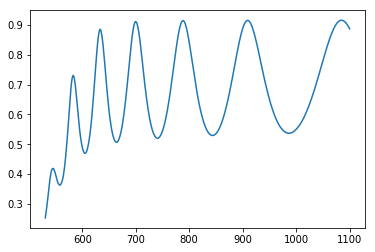

In [5]:
# Plot of thin film transmision:
plt.plot(lambdas, film)
plt.show()

In [6]:
# Swaneopel function for transmision:
def T_at_lambda(lam, n, s, d, alpha):
    """
    n and alpha are NOT functions of lam in this function.
    The function computes equaiton (4) of Swanepoel's paper.
    """
    A = 16*n*n*s
    B = (n+1)**3*(n+s*s)
    C = 2*(n*n-1)*(n*n-s*s)
    D = (n-1)**3*(n-s*s)
    phi = 4*np.pi*n*d/lam
    x = np.exp(-alpha*d)
    return A*x/(B-C*x*np.cos(phi)+ D*x*x)

In [7]:
# Function to get the best list of n and alpha corresponding to fixed s and d:
def get_coefs(lambdas, s, d, experimental):
    def solve_coefs(x, s, d, lam, experimental):
        n = x[0]
        alpha = x[1]
        return abs(T_at_lambda(lam, n, s, d, alpha) - experimental)
    n_list = np.empty(len(lambdas))
    alpha_list = np.empty(len(lambdas))
    diff_list = np.empty(len(lambdas))
    x0 = [1.5, 1e-5]
    for index, lam in enumerate(lambdas):
        #simple minimization:
        #min_info = minimize(solve_coefs, x0=x0, args=(s, d, lam, experimental[index]), bounds=([1, 3], [0, 1e-1]), method='TNC')
        #global minimization:
        minimizer_kwargs = dict(args=(s, d, lam, experimental[index]), bounds=([1, 3], [0, 1e-1]), method='TNC')
        min_info = basinhopping(solve_coefs, x0=x0, minimizer_kwargs=minimizer_kwargs)
        n_sol, alpha_sol = min_info['x']
        x0 = [n_sol, alpha_sol] # new x0
        difference_fit = min_info['fun']
        #print(min_info['message'])
        n_list[index] = n_sol
        alpha_list[index] = alpha_sol
        diff_list[index] = difference_fit
    return n_list, alpha_list, diff_list

Example of how to minimize the difference between the predicted transmittance for a fixed s and d, and the experimental value. This finds the values of n and alpha to minimize such a difference:

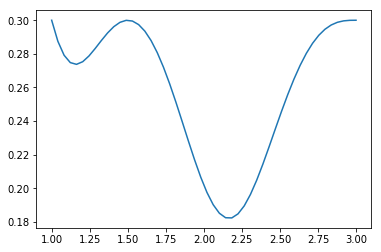

                        fun: 0.18202733176346075
 lowest_optimization_result:      fun: 0.18202733176346075
     jac: array([1.11022302e-08, 2.50738670e+02])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 22
     nit: 4
  status: 1
 success: True
       x: array([2.16502063, 0.        ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1112
                        nit: 100
                          x: array([2.16502063, 0.        ])


In [9]:
def solve_coefs(x, s, d, lam, experimental):
    n = x[0]
    alpha = x[1]
    return abs(T_at_lambda(lam, n, s, d, alpha) - experimental)
#min_info = minimize(solve_coefs, x0= [1.5, 1e-3], args=(3, 300, 900, 0.9), bounds=([1, 3], [0, 1e-1]), method='TNC')
minimizer_kwargs = dict(args=(3, 300, 900, 0.9), bounds=([1, 3], [0, 1e-1]), method='TNC')
min_info = basinhopping(solve_coefs, [1.5,1e-3], minimizer_kwargs=minimizer_kwargs)
alpha_found = min_info['x'][1]

# Plot the difference abs(predicted_transmittance - experimental_transmittance) for a set of refraction index
# values to see if the minimizer works well: 
ns = np.linspace(1, 3)
yplot = [solve_coefs([n, alpha_found], 3, 300, 900, 0.9) for n in ns]
plt.plot(ns, yplot)
plt.show()
print(min_info)

Example of how to get n(lam) and alpha(lam) for a set of lambdas, as well as fixed s and d:

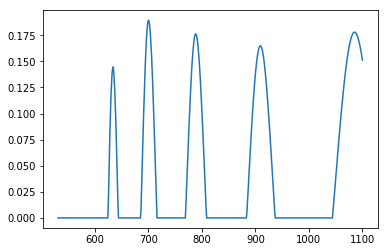

In [10]:
n_list, alpha_list, diff_list = get_coefs(lambdas, 3, 400, film)

# Plot the difference between predicted and experimental transmittance:
plt.plot(lambdas, diff_list)
plt.show()

In [ ]:
def min_s_and_d(X, lambdas, film):
    """
    Function that returns the sum of the differences between predicted and experimental transmittance for all the
    lambdas for fixed s and d.
    """
    s = X[0]
    d = X[1]
    n_list, alpha_list, diff_list = get_coefs(lambdas, s, d, film)
    tot_dist = np.sum(diff_list)
    return tot_dist

#ds = np.linspace(100,200, 50)
#ss = np.linspace(1.2, 2, 50)
#yplot = [min_s_and_d([1.51, d]) for d in ds]
#plt.plot(ds, yplot)
#plt.show()

# Minimize the total difference between predicted and experimental transmittance with respect to s and d:

# Local minimum:
#result = minimize(min_s_and_d, x0= [1.5, 500], bounds=([1, 5], [100, 1000]), method='TNC')
# Global minimum:
minimizer_kwargs = dict(bounds=([1, 5], [100, 500]), method='TNC', args=(lambdas, film))
result = basinhopping(min_s_and_d, [1.5,200], minimizer_kwargs=minimizer_kwargs)

In [ ]:
result

In [42]:
# Test of minimization:

def minthis(X, a):
    x,y=X
    return a*(x+y+1)**2

minimize(minthis, [4,4], args=(3), bounds=([-.2, 7], [-.2, 7]))

      fun: 182.51999999999998
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([46.79999961, 46.79999961])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([-0.2,  7. ])